# Building an Agentic System for YouTube Script Writing with LangGraph and Mistral Small 3

## Introduction

Automating YouTube script writing is an ideal use case to showcase the power of agentic systems. In this article, we will build an agentic system step by step using [**LangGraph**](https://langchain-ai.github.io/langgraph/tutorials/introduction/) and [**LangChain**](https://python.langchain.com/docs/introduction/), following an iterative approach.

We will use [**Mistral Small 3**](https://mistral.ai/en/news/mistral-small-3) as our primary LLM. This choice is strategic as agentic systems allow us to avoid relying on very large models such as *OpenAI GPT-4o*, *Mistral Large*, *Anthropic Claude 3.5 Sonnet*. With this approach, we can achieve advanced results while being more efficient in terms of computational resources.

**Mistral Small 3** covers all our needs for this agentic use case: 
- Low-latency function calling,
- Robust structured output,
- Competitive instruction following,
- Fast-response conversational assistance,
- General knowledge performance that rivals models three times larger.

We will explore how to transition from a single LLM-based writing assistant to a multi-agent system capable of collaborating to produce a high-quality script.

**Note**: 
- This *how-to* is based on the **Video Script** agent from my [AI-Agent-Casebook](https://github.com/BittnerPierre/AI-Agent-Casebook) project on Github.
- This content is a personal initiative and is not part of any ambassador program. 

Don't forget to subscribe to my [Youtube Channel](https://www.youtube.com/@pierrebittner).

## What You Will Learn
- The basics of agentic systems and why they matter
- How to create a **multi-agent** system with LangGraph
- How to evaluate agents and improve their quality
- How to use **Mistral Small 3** as part of automated or agentic workflows
- How to implement a **supervisor** to coordinate agent collaboration

### **Understanding What an Agentic System Is (Collaboration of Agents, Not Just Function Calling)**

An **agentic system** is fundamentally about **collaboration between multiple autonomous agents** to accomplish a complex task. Unlike a traditional **function-calling approach**, where a single model or function sequentially processes inputs, an **agentic system** enables **distributed decision-making**, **specialized roles**, and **dynamic workflow adjustments** based on real-time results.

In this tutorial, we will **not focusing on function calling**, as it plays only a minimal role in our implementation.. Instead, we aim to build an **end-to-end agentic solution** with **fundamental capabilities**, showcasing how independent agents can work together in a structured, modular way.

### **Why Focus on the Basics?**
LangGraph’s official documentation often highlights **advanced features** such as:
- **Human-in-the-loop interventions** (where users can manually approve, edit, or intervene in workflows),
- **Memory management** (persistent state tracking across interactions),
- **Streaming outputs** (real-time updates from LLMs),
- **Complex multi-agent workflows** with intricate dependencies and decision-making.

These advanced features are **powerful but may overwhelm beginners** who are just starting with agentic systems

### **The Goal of This Tutorial**
- Provide a **clear, accessible** introduction to **multi-agent system construction** using **LangGraph**.
- Focus on **core principles**: agent coordination, modularity, and workflow execution.
- **Avoid unnecessary complexity** while still demonstrating the **power of agentic architectures**.

This step-by-step approach ensures that **readers first master the fundamentals** before diving into **more advanced agentic capabilities**.

## Chapter 1: Understanding the Limitations of Classical Approaches

### The Problem with Classical Writing Assistants

Early iterations of writing assistants relied on a single LLM with a RAG knowledge base. Unfortunately, these systems had limitations:

- Excessive reliance on prompts
- Lack of coherence in the generated script
- Difficulty integrating user feedback

### Towards an Agentic Approach

Instead of asking a single model to handle everything, we will break down the writing process into multiple specific tasks assigned to specialized agents:

- **Planning**: Defining chapters and the overall script structure
- **Researcher**: Gathering relevant information
- **Writer**: Generating the content for each section
- **Reviewer**: Editing and validating the script
- **Supervisor**: Managing the workflow and final validation

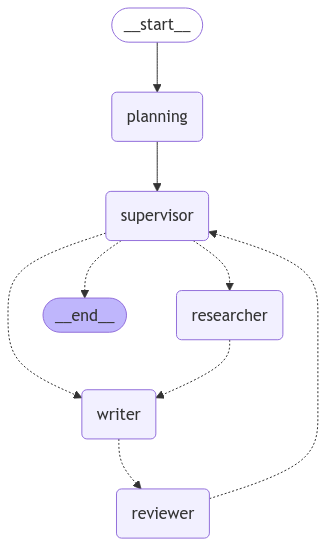

## Chapter 2: Introduction to LangChain Concepts

Before diving into LangGraph, it is crucial to understand the core LangChain concepts that will be used in nodes:

- **Prompt Templates**: Structuring effective prompts for agent interactions.
- **LLM with Structured Output**: Ensuring predictable responses.
- **LLM with Tools**: Allowing agents to interact with external sources.
- **Prompt Hub from LangSmith**: Reusing and managing prompts efficiently.

We will also explore how to test individual nodes before integrating them into a full graph-based workflow.

In [1]:
##############
# Import     #
##############
from typing import TypedDict, Literal, Annotated, List

from dotenv import load_dotenv, find_dotenv
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langchain_mistralai import ChatMistralAI



Now, we load the LangChain MistralAI client, which we will use throughout this notebook.

In [2]:
import getpass
import os


################
# AUTH KEY     #
################

# Import key from .env
_ = load_dotenv(find_dotenv())

# You'll need following key in you .env
# MISTRAL_API_KEY=vx...
# for LC Prompt Hub
# LANGCHAIN_API_KEY=lsv2_pt...


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("MISTRAL_API_KEY")
_set_env("LANGCHAIN_API_KEY")



In [3]:
################
# COMMON     #
################

# Mistral Small 3 available on Mistral AI 'La Platforme'
llm = ChatMistralAI(model="mistral-small-latest")



Here is the code of our first agent: the researcher.

In [64]:
####################
# RESEARCHER AGENT #
####################

# Define output format
class Research(TypedDict):
    research: str
    comment: str


researcher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            f"""
            You are the **Researcher** in a team responsible for scriptwriting YouTube videos.
            Your role is to **gather, verify, and organize** relevant information to support scriptwriter in producing accurate and engaging content.  
            
            ### Responsibilities:
            - Provide **exhaustive, detailed, well-organized, contrasted and factual** information
            to feed the writer for all topics on the agenda. 
            - **No assumptions or generic statements**—only verifiable, specific facts or knowledge.
            - **Incorporate feedback** to refine and improve your research.  
            - **You do not write the script.**
            - **You do not plan the agenda.**
            - **You do not review or make critics.**

            ### Constraint:
            The scriptwriter will not have access to any other source than your research.
            - Ensure that all necessary information is provided in your response.  
            - Do not assume the scriptwriter knows background details—explain key concepts where needed.  
            - Use reliable **sources** whenever possible to support claims.
            
            #### Expected Output Format:
            1. **Research**  
               - Organize your research with **numbered sections, subsections, bullet points, and hyphens** following the agenda for clarity.  
               - Include **sources** whenever possible.  
            2. **Comment**  
               - Use plain text to add **research notes** or respond to feedback.  
               - If informations are missing, state it here.
            
            #### Additional Notes:
            - Maintain a **clear and structured** format for readability.  
            - Avoid using **JSON, XML, or code-like formats.** Stick to plain text.  
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

researcher = researcher_prompt | llm.with_structured_output(Research)

This is a simple LLM chain with structured output. However, in real-world applications, you’ll likely need to extend it by integrating function calling or RAG (Retrieval-Augmented Generation) to enhance accuracy.

You can take inspiration from the [Research Team](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/?h=#research-team) of [Hierarchical Agent Teams](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/?h=#hierarchical-agent-teams) on LangGraph Documentations.

We will keep 'research agent' as is for simplification.

Let's test this researcher agent. We define a conversation from a 'Human' and the 'Planner' .

In [5]:
# Emulate a conversation

input = [
        ("human", """I would like a two-chapter video, 2 minutes long, containing 450 words on the topic
            'AI will not take your job. Those who use AI will!'"""),
        ("assistant", """Here's a suggested agenda for your 2-chapter video on 'AI will not take your job. Those who use AI will!'

    ### Chapter 1
    1. **Title**
    AI will not take your job. Those who use AI will! (200 words):
    
    2. **Brief**
    Introduction of the video, presentation of the topic, and key points to be covered.
    
    3. **Covered Topics**
    - Understanding AI's role in the job market
    - The benefits of AI for workers
    - The skills needed to work with AI

    ### Chapter 2
    1. **Title**
    AI and Career Opportunities (250 words):
    
    2. **Brief**
    Presentation of companies that are succeeding thanks to AI, the skills in demand, and career opportunities.
    
    3. **Covered Topics**
    - Companies that have succeeded with AI
    - Skills sought by employers
    - Career opportunities with AI"""),
        ("human", "Provide research for the video."),
    ]


To call the agent, simply provide the conversation history along with a team description as input to the ```invoke``` method.

As our agent is a LangChain runnable, you could stream, batch or make asynchronous call. Sweet! But we just invoke here.

In [7]:
researcher_res = researcher.invoke(input={"messages": input})
print(researcher_res)

{'research': "Chapter 1\n\n1. **Introduction to AI's Role in the Job Market**\n\n- **Definition of AI**: Artificial Intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to think and learn like humans.\n\n- **Impact on the Workforce**: AI is changing the job market by automating repetitive tasks, increasing efficiency, and creating new roles.\n\n- **Stats and Facts**:\n  - According to a World Economic Forum report, while AI may displace 85 million jobs by 2025, it could also create 97 million new jobs.\n  - A McKinsey report suggests that as much as 30% of the tasks in around 60% of occupations could be automated with today's technology.\n\n- **Sources**:\n  - World Economic Forum: The Future of Jobs Report 2020\n  - McKinsey & Company: Jobs lost, jobs gained: What the future of work will mean for jobs, skills, and wages\n\n2. **Benefits of AI for Workers**\n\n- **Efficiency and Productivity**: AI tools can handle routine tasks, freeing up ti

You should get 2-chapter research and a comment. The quality of research may vary. This is 'normal' based on the stochastic nature of LLM outputs.

This is fine for now. Later, we will introduce a 'reviewer' agent to ensure the quality of the research content. Also, we will move our scriptwriting workflow to operate chapter per chapter to mitigate this by letting the agent work on a smaller chunk of task.

Next, we will see an important practice in agentic agent and will introduce the concept of how an llm agent can 'review' the work of another one.

### Good Practice #1: Agent Evaluation

It is essential to have a robust evaluation system in place from the beginning to ensure steady progress while developing your agentic workflow.

As llm answer can change we will use llm-as-judge to evaluate our agent answer.

In [8]:
research_evaluator_prompt = ChatPromptTemplate.from_template("""
### **Evaluation Prompt for Research (AI as Judge)**  

You are an evaluator assessing the relevance and adequacy of research results based on a defined **story request** 
and a **suggested agenda**. 

Your goal is to determine whether the provided research aligns with the requested topic and provides useful, structured, and relevant information.  

Here is the evaluation data:
[BEGIN DATA]  
************  
<Request>
{input}
</Request>
************  
<Research>
{response}
</Research>
************
[END DATA]  

#### **Evaluation Process**  
1. **Relevance to Request**  
   - Does the research directly address the requested chapter and its covered topics?  
   - Does it stay within the intended scope without deviating into unrelated areas?  

2. **Alignment with Proposed Planning**  
   - Does the research sufficiently cover the key points outlined in the planning?  
   - Are the topics appropriately developed to provide meaningful insights?  

3. **Usefulness & Informational Value**  
   - Is the research **clear, structured, and informative**?  
   - Does it provide **credible information** (facts, explanations, or sources where applicable)?  
   - Can the content be **directly used** for the requested video script without requiring excessive modifications?  

#### **Evaluation Criteria (Score 0-10)**  
- **8-10**: The research is highly relevant, well-structured, and directly usable for the script.  
- **6-8**: Mostly aligned but may lack minor details or refinement.  
- **4-6**: Partially aligned, missing key elements or requiring significant rework.  
- **2-4**: Misaligned with the request, lacks important aspects, or includes off-topic content.  
- **0-2**: Irrelevant or not useful for the intended purpose.  

#### **Response Format:**  
**Grade:** <ACCEPTABLE or UNACCEPTABLE>  
**Score:** <0-10>  
**Comment:** <Brief justification for the score, highlighting any gaps or misalignment>  
""")

LLM as judge is very easy to setup with LC.

In [9]:
class ScriptEvaluatorFeedback(TypedDict):
    Grade: Literal['ACCEPTABLE', 'UNACCEPTABLE']
    Score: int
    Comment: str

research_evaluator = research_evaluator_prompt | llm.with_structured_output(ScriptEvaluatorFeedback)


def valid_research(input: str, output: str) -> ScriptEvaluatorFeedback:
  """Use an LLM to judge if the research is consistent."""

  res = research_evaluator.invoke(input={"input": input, "response": output})
  return res


def test_researcher(agent, input):

    output = agent.invoke(input={"messages": input})

    res = valid_research(input, output)

    assert res["Grade"], "Acceptable"
    return res


I advice you to go further with LangSmith on [LLM as Judge](https://docs.smith.langchain.com/evaluation/how_to_guides/llm_as_judge) with  dataset and evaluator and include it in your test set. 

In [12]:
test_researcher(researcher, input)

{'Grade': 'ACCEPTABLE',
 'Score': 7,
 'Comment': "The research aligns well with the requested topics and the suggested agenda. It covers the key points outlined for both chapters, including AI's role in the job market, benefits for workers, skills needed, and career opportunities. However, it lacks specific examples and detailed information, which would enhance its usefulness for the script. The structure is clear, but more content development is needed to make it directly usable for the video script without extensive modifications."}

Result will be probably evaluated as 'UNACCEPTABLE'.  

There are several strategies to improve that, like performing external search as stated before or operate chapter per chapter. 
We will cover the 2nd stategy later.

Again this is not very important at this stage, we want to keep research agent simple.

For our demo purpose, **Mistral Small 3** has sufficient 'world knowledge' to produce **good enough** research. 

### Good Practice #2: Prompt-Oriented Architecture

In GenAI app development, it's a best practice to decouple business logic from prompt engineering since prompts and system instructions follow a distinct lifecycle from the application's core logic. 

By treating prompts as modular and reusable assets, developers can iterate independently, conduct A/B testing, and integrate seamlessly with LLM orchestration frameworks like LangChain or LlamaIndex.

Tools such as [LangSmith](https://smith.langchain.com/) Prompt Hub enable prompt versioning and evaluation, ensuring optimal performance without entangling prompt design with backend workflows.

So next, we'll declare the 'scriptwriter' prompt directly in prompt hub.

In [13]:
from langchain import hub
from langsmith.utils import LangSmithConflictError

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are the **Scriptwriter** in a team responsible for scriptwriting YouTube videos.

            Your job is to:
            - Write or improve a video script based on the agenda and information given.
            - Make changes based on feedback to improve your script.
            - Only use the information provided; do not do additional research.
            
            ### How to Format Your Output
            1. Put the **full script** in the `chapter` section. Write it as plain text without any formatting.
            2. Put any notes, responses to feedback, or extra suggestions in the `comment` section. Write these as plain text, like a conversation.
            
            ### Important Points
            - Do not use structured formatting (like JSON or XML) in the `comment` section.
            - If you need more information, say so in the `comment` section.
            - Make sure the `chapter` text is clear and complete without relying on formatting.
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
# langsmith create an error if prompt's content does not change. So we catch the error. 
try:
    hub.push(repo_full_name="tuto-video-script-writer-prompt", object=writer_prompt, new_repo_is_public=False)
except LangSmithConflictError as e:
    print(f"Prompt has not changed.'{e}'")

Prompt has not changed.'Conflict for /commits/-/tuto-video-script-writer-prompt. HTTPError('409 Client Error: Conflict for url: https://api.smith.langchain.com/commits/-/tuto-video-script-writer-prompt', '{"detail":"Nothing to commit: prompt has not changed since latest commit"}')'


Then, we will use the writer prompt to create the writer agent

In [14]:
##############
# WRITER     #
##############

class Draft(TypedDict):
    script: str
    comment: str

In [15]:
writer_prompt = hub.pull("tuto-video-script-writer-prompt")
writer = writer_prompt | llm.with_structured_output(Draft)

We can do the same with the previously declared researcher prompt.

```python
try:
    hub.push(repo_full_name="tuto-video-script-researcher-prompt", object=researcher_prompt, new_repo_is_public=False)
except LangSmithConflictError as e:
    print(f"Prompt has not changed.'{e}'")


researcher_prompt = hub.pull("tuto-video-script-researcher-prompt")
researcher = researcher_prompt | llm.with_structured_output(Research)
```

If you don't want to use Prompt hub yet, use this script to declare writer agent

```python
writer = writer_prompt | llm.with_structured_output(Draft)
```

Let's test the 'writer agent'.

First, we will format a message for the writer based on the result of research.

In [16]:
researcher_res_comment = researcher_res.get('comment', 'No comment provided.')
researcher_res_content = researcher_res['research']
research_message_content = (f"# Research "
                            f"\n\n{researcher_res_content}"
                            f"\n\n-----\n\n# Researcher Comment"
                            f"\n\n{researcher_res_comment}")

In [17]:
research_message_content

"# Research \n\nChapter 1\n\n1. **Introduction to AI's Role in the Job Market**\n\n- **Definition of AI**: Artificial Intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to think and learn like humans.\n\n- **Impact on the Workforce**: AI is changing the job market by automating repetitive tasks, increasing efficiency, and creating new roles.\n\n- **Stats and Facts**:\n  - According to a World Economic Forum report, while AI may displace 85 million jobs by 2025, it could also create 97 million new jobs.\n  - A McKinsey report suggests that as much as 30% of the tasks in around 60% of occupations could be automated with today's technology.\n\n- **Sources**:\n  - World Economic Forum: The Future of Jobs Report 2020\n  - McKinsey & Company: Jobs lost, jobs gained: What the future of work will mean for jobs, skills, and wages\n\n2. **Benefits of AI for Workers**\n\n- **Efficiency and Productivity**: AI tools can handle routine tasks, freeing up 

Next, we prepare messages input for the writer. We take previous conversation on which we append research result and writer instructions.

In [18]:
writer_input = input + [("assistant", research_message_content), 
          ("human", "Write the script for the video using agenda and research.") ]

In [19]:
writer_res = writer.invoke(input={"messages": writer_input})

In [20]:
writer_res

{'script': "Chapter 1: AI will not take your job. Those who use AI will! \n\nArtificial Intelligence, or AI, is transforming the job market. It's important to understand that AI isn't here to replace humans but to augment our capabilities. AI excels at automating repetitive tasks, increasing efficiency, and providing data-driven insights. \n\nAccording to a World Economic Forum report, while AI may displace 85 million jobs by 2025, it could also create 97 million new jobs. A McKinsey report suggests that as much as 30% of the tasks in around 60% of occupations could be automated with today's technology. \n\nSo, how can workers benefit from AI? Firstly, AI tools can handle routine tasks, freeing up time for creative and strategic work. This means workers can focus on what they do best—innovating and problem-solving. \n\nSecondly, AI can aid in decision-making by providing data-driven insights. This helps workers make more informed decisions, leading to better outcomes. For instance, AI 

# Chapter 3: Creating a Minimal Skeleton of our Agentic Workflow (Planner + Researcher +Writer)

Defining an Initial Graph

To start, we create a simple workflow with two agents:

1. **Planner**: Determines the script structure (agenda, key topic, brief).
2. **Researcher**: Generates research based on the agenda.
3. **Writer**: Generates the script based on the agenda + research.

In LangGraph, an agentic workflow is described using a graph representation. So will have to define a [Graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs), [Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) and [Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges).

Let's now create the planning step. This will be used by the team to guide during their script writing  process.

In [21]:
class Chapter(TypedDict):
    title: str
    covered_topics: List[str]


class Planning(TypedDict):
    topic: str
    plan: List[Chapter]

In [22]:
producer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are the 'producer' in a team responsible for scriptwriting YouTube videos.\n\n"
            "Your responsibilities:\n"
            "- Plan the video agenda: \n"
            "Define for each section:"
            " - Title [words count]\n"
            " - covered topics (max 3)\n"
            "- Decide which team members should act 'next' or provide 'approval' for the script revision to move forward.\n"
            "You ensure that the process is efficient by limiting iteration or superfluous revision.\n"
            "The video must follow this template :\n"
            "- Section 1: Video hook and intro\n"
            "- Section 2: Body, main content \n"
            "- Section 3: CTA (call to action) and Conclusion\n"
            "\n\n"
            "You DO NOT write script.\n"
            "You DO NOT make research."
            "You DO NOT review.\n"
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

planner = producer_prompt | llm.with_structured_output(Planning)

In [23]:
planner_prompt = PromptTemplate.from_template(
    "Elaborate the plan of the video script. \n"
    "Define for each chapter:\n"
    " - Chapter 'Title' (including words count directive for the chapter in format '[X words]')\n"
    " - Covered topics (max 3 per chapter) with specific and actionable direction.\n"
    " - Brief for the chapter explaining where you want to go.\n"
    "You provide information that guide your team to deliver the story you envision.\n"
    "\n\n"
    "The video plan must follow this structure :\n"
    "- 'Opening Section': contains video hook and introduction.\n"
    "- 'Main Section': 'Body' of the script where you develop the X chapters.\n"
    "- 'Closing Section': contains the CTA (call to action) and a brief conclusion.\n"
    "\n\n"
    "Opening and Closing section does not count as 'user chapters'. "
    "If user ask for 3 chapters, you must plan for 5 (1: Hook+Introduction, 2,3,4: user chapters, 5: CTA+Conclusion)"
)
try:
    hub.push(repo_full_name="tuto-video-script-planner-prompt", object=planner_prompt, new_repo_is_public=False)
except LangSmithConflictError as e:
    print(f"Prompt has not changed.'{e}'")

Prompt has not changed.'Conflict for /commits/-/tuto-video-script-planner-prompt. HTTPError('409 Client Error: Conflict for url: https://api.smith.langchain.com/commits/-/tuto-video-script-planner-prompt', '{"detail":"Nothing to commit: prompt has not changed since latest commit"}')'


In [24]:
from langgraph.graph.message import add_messages
from langchain_core.messages import  BaseMessage

class VideoScriptState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    chapters: List[Chapter]

In LangGraph, the Graph's *'State'* is a **shared data structure** that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.

It is what will collect the messages produced by each agent within the workflow. But you can use it to share any information each component in your graph need to collaborate.

To simplify our like, LangGraph provide reducer to automatically merge output of node. There is one specific for handling [message state](https://langchain-ai.github.io/langgraph/how-tos/state-reducers/#messagesstate).

In the snippet above: ```from langgraph.graph.message import add_messages```and ```messages: Annotated[List[BaseMessage], add_messages]```

Here, we will add the chapter generated by the 'planner_node' that will be used by 'researcher' and 'writer'.

Why that? We want to handle at a granular level what each node works on. We cannot only rely on the conversation as it may become very long and agent could start to be confused. 

Let's define a node for Planner, researcher and writer. The planner node is the 'host/producer' agent with a specific prompt to create the agenda.

We parse the output of **'planner'** agent to add its content directly in the **'VideoStateGraph'** in **'chapter'** field..

In [25]:
#####################
# TOOLING
#####################

def _format_chapters(chapters):
    formatted_chapters = ""
    for chapter in chapters:
        formatted_chapters += f"{chapter['title']}:\n"
        if 'chapter_brief' in chapter:
            formatted_chapters += f"  - Brief: {chapter['chapter_brief']}\n"
        formatted_chapters += "  - Covered Topics:\n"
        for topic in chapter['covered_topics']:
            formatted_chapters += f"    - {topic}\n"
        formatted_chapters += "\n"
    return formatted_chapters

In [26]:
def planner_node(state: VideoScriptState) -> VideoScriptState:
    """
    The Host/Producer sets the plan (how many chapters, the overall direction).
    In a real scenario, you'd call host_producer_prompt with the user request to produce an agenda.
    We'll simulate it here.
    """
    # If not already done, let's define chapters in the conversation or from user input
    # Example simulation: The user wants a 3-chapter video, so we store that:
    if not state.get("chapters"):

        planner_prompt = hub.pull("tuto-video-script-planner-prompt")
        message_content = planner_prompt.format()
        messages = state["messages"] + [HumanMessage(content=message_content, name="user")]
        res = planner.invoke(input={"messages": messages})
        chapters = res['plan']
        state["chapters"] = chapters
        formatted_chapters = _format_chapters(chapters)
        producer_message = (f"Here's a suggested agenda for your video."
                            f"\n\n{formatted_chapters}")
        host_message = AIMessage(content=producer_message, name="host-producer")
        state["messages"].append(host_message)
    return state

### Command: A new tool for building multi-agent architectures in LangGraph

For the next nodes, we will use a new addition to LangGraph arsenal : [*'Command'*](https://langchain-ai.github.io/langgraph/how-tos/command/)

In [27]:
from langgraph.types import Command

In [28]:
def researcher_node(state: VideoScriptState) -> Command[Literal["writer"]]:
    """
    The Researcher provides factual data/ideas for the current chapter.
    For demonstration, we just append a dummy 'AIMessage' with bullet points.
    """
    chapters = state["chapters"]
    message_content = f"Provide research for the video covering the key topics of agenda."
    human_message = HumanMessage(content=message_content, name="user")
    messages = state["messages"] + [human_message]

    res = researcher.invoke(input={"messages": messages})

    research_response_comment = res.get('comment', 'No comment provided.')
    research_chapter_content = res['research']
    research_message_content = (f"# Research"
                                f"\n\n{research_chapter_content}"
                                f"\n\n-----\n\n#Comment"
                                f"\n\n{research_response_comment}")

    return Command(
        update={
            "messages": [AIMessage(content=research_message_content, name="researcher")],
        },
        goto="writer",
    )

In [29]:
def writer_node(state: VideoScriptState) -> Command[Literal["__end__"]]:
    """
    The Writer composes or updates the script for the current chapter using the research input.
    """
    chapters = state["chapters"]
    message_content = f"Write the script using agenda and research."
    human_message = HumanMessage(content=message_content, name="user")
    messages = state["messages"] + [human_message]

    res = writer.invoke(input={"messages": messages})

    # Check if 'comment' is in the response
    writer_script_content = res['script']
    writer_response_comment = res.get('comment', 'No comment provided.')

    writer_message_content = (f"# Script"
                              f"\n\n{writer_script_content}\n\n-----"
                              f"\n\n# Writer Comment"
                              f"\n\n{writer_response_comment}")

    return Command(
        update={
            "messages": [AIMessage(content=writer_message_content, name="writer")],
        },
        goto="__end__",
    )

In [30]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(VideoScriptState)
workflow.add_node("planning", planner_node)
workflow.add_node("researcher", researcher_node)
workflow.add_node("writer", writer_node)
workflow.add_edge(START, "planning")
workflow.add_edge("planning", "researcher")

Of course, LangGraph need to store the state of the graph somewhere. It use Memory for that. For real use case,
you must use persistant memory but for this demo we will use MemorySaver.

In [31]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

And at the end, we compile the Graph. LangGraph will check its consistency so you can have error.

In [32]:
video_script_app = workflow.compile(checkpointer=memory)

We will exlain the 2 approaches here:

- **'planning_node'** function return an updated *'StateGraph'* and the *'edge'* between **'planning_node'** and **'writer_node'** is declare at graph level with *'add_edge'* method.
- **'researcher_node'** and **'writer_node'** use *'Command'* and its attribute *'goto'* to create the *'edge'* between them. It is also in the signature of the function (return). Command is an important addition to LangGraph to allow dynamic workflow. Change on *'StateGraph'* is transfer via the *'update*' parameter. This allow *handoff* between agents in the graph.

If you prefer the first method, you can use 'add_conditional_edge' method of stategraph for decision making. Take care, you cannot combined both approach (ie. a node that return a Command and a conditional_edge on the graph).

Let's see what our graph looks like.


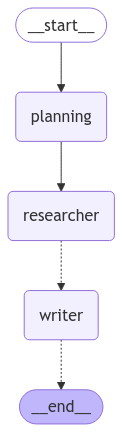

In [33]:
from IPython.display import Image, display

try:
    display(Image(video_script_app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

We have a linear process '__start__' --> 'planning' --> 'researcher' --> 'writer' --> '__end__' which starts to look like something we could do in real-life. You see that the edges are not the same (continuous versus dotted line) showing the two approach.

So we are not in an agentic workflow yet as each next step is known in advance and no agent decide what to do next (decision making / reasonning). But we have already moved away from the *'llm-chain'* paradigm. 

Let's run the graph now.

In [34]:
prompt = ("I'd like a 2-chapter video of 2 minutes of 450 words on 'AI Won't Take Your Jobs. Those Who Use AI Will!'")

config = {"configurable": {"thread_id": "1"}}

example_input = {
    "messages": [("human", prompt)],
}

# Collect all steps from the astream generator
steps = [step for step in video_script_app.stream(example_input, config=config, stream_mode="values")]

# Access the last step
last_step = steps[-1]

print(f"Directive: '{prompt}'")

# Print the last message of the last step
last_message = last_step["messages"][-1]

output = last_message.pretty_repr()
print(f"Result: '{output}'")


Directive: 'I'd like a 2-chapter video of 2 minutes of 450 words on 'AI Won't Take Your Jobs. Those Who Use AI Will!''
Result: '================================== Ai Message ==================================
Name: writer

# Script

Opening Section: AI Revolution  We are living in the midst of an AI revolution.   AI, or Artificial Intelligence, refers to the simulation of human intelligence processes by machines, especially computer systems. These processes include learning, reasoning, and self-correction. The concept of AI has been around since the 1950s, but recent advancements in machine learning, natural language processing, and big data have accelerated its development and integration into various industries. Today, AI powers virtual assistants like Siri and Alexa, complex decision-making systems in finance and healthcare, and much more.  But here's the thing: AI won't take your jobs. Those who use AI will!  This phrase highlights a crucial shift in how we think about AI in the wo

What's important here is ```config = {"configurable": {"thread_id": "1"}}```

You have to define a **'thread_id'** for each user. This is mandatory because StateGraph is statefull. You remember the 'MemorySaver' we have added when we compile the graph. So you have to identify the user uniquely.

LangChain use **'session_id'** to handle conversation history per user. So you'll have to initialize both value if you are using advanced chain like *'RunnableWithMessageHistory'*. 

So if you are already using LC, take care: LC and LG does not use the same *keyword* for memory management.

In this notebook, we can simply use 1 as value but for real application you will probably have a code like:

```python
import uuid

thread_id = config.configurable.get("thread_id") if config and hasattr(config, 'configurable') else str(uuid.uuid4())
```

uuid helps to generate unique id.

2nd interesting things is that langgraph work per step (and handle everything smoothly for you). It will orchestrate the call between all agent. We won't go into the detail of what is going while langgraph is executing the process. Here, we just retrieve the last step and display the last message.

StateGraph is also a runnable (like LangChain chain) so you have all the nice feature with async calling, streaming, batching etc. You also have access granularly to all events during execution to display progress to user.

## Chapter 4: Agentic Evaluation and Simulation

Like agent, you have to test you agentic worklow. 

Here we will use the same strategy has research but for final script. For conversational agent, you will use a [Simulator agent](https://langchain-ai.github.io/langgraph/tutorials/chatbot-simulation-evaluation/agent-simulation-evaluation/) that will *'simulate'* a human interaction with AI Assistant. Here, we have a fully automatized process, we'll just evaluate the final results. 

I recommend to set up more advanced evaluation. LangSmith is very convenient for that. They have a good documentation for [graph evaluation](https://docs.smith.langchain.com/evaluation/how_to_guides/langgraph) covering other approaches like evaluating intermediate steps or running and evaluating individual nodes).

In [35]:
script_evaluator_prompt = ChatPromptTemplate.from_template("""
You are evaluating a submitted script based on the given request. 

Here is the evaluation data:
[BEGIN DATA]  
************  
<Request>
{input}
</Request>
************  
<SubmittedScript>
{response}
</SubmittedScript>
************
[END DATA]  

Compare the submitted script with the request.  
Ignore differences in style, minor phrasing, or wording variations.  

Assess alignment based on:  
- **Structure**: Does it follow a logical **chapitrage** (proposed agenda)?  
- **Angle**: Does the story perspective fit the topic?  
- **Length & Duration**: Is it reasonably aligned with expectations?  
- **Language**: Does the script is in the expected language (same as request if user not specify)?  
- **Quality**: Is it coherent, engaging, and suitable for a YouTube AI audience?  

**Grade the result:**  
- **8 to 10**: Fully meets the request across all aspects.  
- **6 to 8**: Mostly aligned, with minor gaps.  
- **4 to 6**: Partially aligned, missing key aspects.  
- **2 to 4**: Significant misalignment with the request.  
- **0 to 2**: Off-topic or completely missing expectations.  
If the submission is entirely missing or contains no meaningful content (ex: None), assign a score of 0.
The script is **ACCEPTABLE** if the score is above 6. It is **UNACCEPTABLE** if the score is below 6.  

**Answer format:**  
Grade: <ACCEPTABLE or UNACCEPTABLE>  
Score: <grade from 0 to 10>"**  
Comment: <Brief justification for the score, highlighting any gaps or misalignment>  
""")

In [36]:
import uuid

script_evaluator = script_evaluator_prompt | llm.with_structured_output(ScriptEvaluatorFeedback)


def valid_script(input: str, output: str) -> ScriptEvaluatorFeedback:
  """Use an LLM to judge if the script is consistent."""

  res = script_evaluator.invoke(input={"input": input, "response": output})
  return res


def test_script(agent, input):

    thread_id = config.configurable.get("thread_id") if config and hasattr(config, 'configurable') else str(
        uuid.uuid4())

    effective_config = {"recursion_limit": 99, "configurable": {"thread_id": thread_id}}

    input_data = {'messages': [HumanMessage(content=input)],}

    steps = [step for step in agent.stream(input=input_data, config=effective_config, stream_mode="values")]

    # Access the last step
    last_step = steps[-1]

    # Print the last message of the last step
    last_message = last_step["messages"][-1]
    output = last_message.pretty_repr()

    # output = agent.invoke(input={"messages": input})

    res = valid_script(input, output)

    assert res["Grade"], "Acceptable"
    return res


In [37]:
test_script(video_script_app, prompt)

{'Grade': 'ACCEPTABLE',
 'Score': 8,
 'Comment': 'The script is well-aligned with the request. It follows a logical structure with a clear introduction, two chapters, and a concluding call to action. The angle is appropriately focused on how AI creates job opportunities and the importance of AI literacy, fitting the topic well. The length is reasonable for a 2-minute video, and the language is suitable for a YouTube AI audience. The content is coherent, engaging, and provides practical steps for the audience. Minor improvements could be made in terms of depth and more specific examples, but overall, it meets the request effectively.'}

This is basic testing but it is very simple to implement and as your workflow start to complexify, you must have a robust testing strategy in place from the beggining.

If you look carefully at the test_script function, you'll notice that I've added a **"recursion_limit"** parameter to the configurable.

This is crucial because, from this point on, we will introduce 'branches' and 'loops' into our graph, and we don't want our workflow to enter an infinite loop, especially since decision-making will be handled by autonomous agents. Setting a **'recursion_limit'** prevents the AI agent from running indefinitely and consuming excessive credits.

# Chapter 5: Supervisor node

Now, we will move toward a real agentic workflow. A supervisor agents will orchestrate worker agents and make decision on what to do next.

First, we will add a new member in the script writing team: the **'reviewer'**.

Reviewer will be in charge to check the quality of the research and the script and give advice for enhancement. It will advice the supervisor if the next task must be directed to 'researcher' (if more information is needed) or to the 'writer' if only style or structure revision is required. He can also 'approved' the script if it is ok for him. 

But for good measure, we will redeclare import in one cell so we won't have to search for them.

In [38]:
# redeclaring import here to avoir searching in different cells.
from typing import TypedDict, Literal, Annotated, List,  Tuple

from langgraph.types import Command
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage

from langgraph.graph.message import add_messages
from langchain_core.messages import  BaseMessage

from langchain import hub
from langsmith.utils import LangSmithConflictError

import operator

from langgraph.graph import StateGraph, START, END

from langgraph.checkpoint.memory import MemorySaver

In [62]:
class ReviewFeedback(TypedDict):
    GoodPoints: str
    MissingOrNeedsResearch: str
    SuperfluousContent: str
    StyleRefinement: str
    NextNode: Literal['researcher', 'writer', 'approved']

review_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are the `Reviewer` in a team responsible for scriptwriting YouTube videos.\n\n"
            """Based solely on the proposed key topics and brief from the agenda and writing guidelines,
            your task is to evaluate the script draft and provide concise and structured feedback in four parts:

            1. **GoodPoints**: List the positive aspects that should be retained.
            2. **MissingOrNeedsResearch**: Specify missing information or areas that require more research.
            3. **SuperfluousContent**: Identify anything unnecessary or off-topic in the chapter.
            4. **StyleRefinement**: Major issues with writing guidelines such as word counts per chapter or repetition.
            5. **NextNode**: Indicate the next action by choosing one of:
               - 'approved': If no major revisions or research are necessary.
               - 'writer': If Superfluous Content or Style Refinement BUT NO NEW CONTENT.
               - 'research': If Missing Or Needs Research to address gaps or improve accuracy from the agenda.

            ---

            ### **Decision-Making Guidance for NextNode**:
            1. Choose **'approved'** (default) if issues are minor or stylistic.
            2. Choose **'writer'** if structural or stylistic improvements are required AND NO NEW content is required.
            3. Choose **'research'** if missing content.
            **IMPORTANT**: 'writer' cannot do his own research independently. Go to 'research' any time new content is necessary.
            In case of ambiguity or perplexity, choose 'research'.
            ---
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reviewer = review_prompt | llm.with_structured_output(ReviewFeedback)

Nothing particular to comment here.

Let's define the **'reviewer_node'**.

In [40]:
def reviewer_node(state: VideoScriptState) -> Command[Literal["supervisor"]]:
    """
    The 'Reviewer' agent checks the current draft:
      - If acceptable, we finalize the chapter.
      - If not acceptable, we request changes => 'draft_node' or 'researcher_node' again.
    """

    human_message = HumanMessage(content=f"Review the draft of the chapter", name="user")
    messages = state["messages"] + [human_message]

    res = reviewer.invoke(input={"messages": messages})

    reviewer_message_content = (
        f"# Reviewer Feedback\n\n"
        f"Good Points:\n {res['GoodPoints']}\n\n"
        f"Missing or Needs Research:\n {res['MissingOrNeedsResearch']}\n\n"
        f"Superfluous Content:\n {res['SuperfluousContent']}\n\n"
        f"Style Refinement:\n {res['StyleRefinement']}\n\n"
        f"next: {res['NextNode']}\n\n"
    )

    return Command(
        update={
            "messages": [AIMessage(content=reviewer_message_content, name="reviewer")],
            "next": res["NextNode"],
        },
        goto="supervisor",
    )

'Reviewer' gives feedback on the quality of the script revision (good points) to keep it and what is missing or need to be change.

We have also ask reviewer to give what he estimates to be the 'best' next node that the supervisor should redirect or if he approves the last iteration of the script. For example, we only need style revision, no need to do new research. But if content is missing, we should look for it with the research agent.

In real-case scenario, you will have to give 'Guidelines' to each agent to ensure a coherency in style/tone/structure, etc... and avoid infinite revision.

The next agent will be pass through the State of the graph so we add the field **'next'** in it.

In [41]:
class VideoScriptState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    chapters: List[Chapter]
    next: Literal['researcher', 'writer', 'approved']

Now we will create a supervisor node that will orchestate the job between each agent chapter per chapter.

In [42]:
members = ["researcher", "writer"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + [END]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the initial user request and advice from reviewer,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and comments. When finished,"
    " respond with 'approved'."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to 'approved'."""
    next: Literal['researcher', 'writer', 'approved']



def supervisor_node(state: VideoScriptState) -> Command[Literal[*options]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    host_message = HumanMessage(content="What to do next?", name="host-producer")
    messages += [host_message]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "approved":
        goto = END

    return Command(goto=goto, update={"next": ""})

This is a basic version of supervisor. We'll update it later to handle chapter-based execution.

We need to redirect writer to reviewer. Another solution could have be to redirect all worker node to supervisor but it add an additional step which could be avoided.

In [45]:
def writer_node(state: VideoScriptState) -> Command[Literal["reviewer"]]:
    """
    The Writer composes or updates the script for the current chapter using the research input.
    """
    chapters = state["chapters"]
    message_content = f"Write the script using agenda and research."
    human_message = HumanMessage(content=message_content, name="user")
    messages = state["messages"] + [human_message]

    res = writer.invoke(input={"messages": messages})

    # Check if 'comment' is in the response
    writer_script_content = res['script']
    writer_response_comment = res.get('comment', 'No comment provided.')

    writer_message_content = (f"# Script"
                              f"\n\n{writer_script_content}\n\n-----"
                              f"\n\n# Writer Comment"
                              f"\n\n{writer_response_comment}")

    return Command(
        update={
            "messages": [AIMessage(content=writer_message_content, name="writer")],
        },
        goto="reviewer",
    )

In [46]:
workflow = StateGraph(VideoScriptState)
workflow.add_node("planning", planner_node)
workflow.add_node("researcher", researcher_node)
workflow.add_node("writer", writer_node)
workflow.add_node("reviewer", reviewer_node)
workflow.add_node("supervisor", supervisor_node)
workflow.add_edge(START, "planning")
workflow.add_edge("planning", "supervisor")

memory = MemorySaver()
video_script_workflow = workflow.compile(checkpointer=memory)

Let's display it.

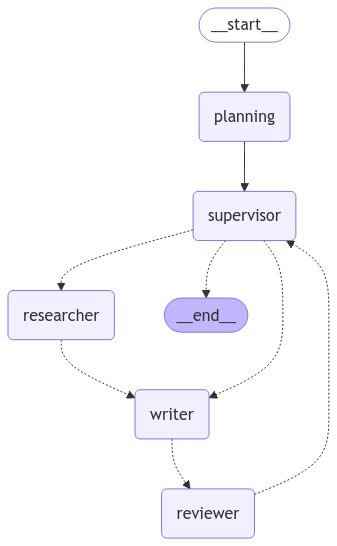

In [47]:
from IPython.display import Image, display

try:
    display(Image(video_script_workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we are getting some serious stuff. 

We won't try to execute this graph because reviewer won't be happy with research and script and will certainly go into an infinite revision cycle. To improve the quality of worker's output, we need to split the job into simpler task and let the supervisor manage the progress iteratively. The logical approach for scritpwriting is to work chapter by chapter.

# Chapter 6. Updating the Supervisor to Work Chapter by Chapter and Max Iteration

To implement chapter-by-chapter execution and handle a max iteration per chapter, we need to modify VideoScriptState to track:

1. The current chapter index (which chapter we are working on).
1. A counter for how many times a chapter has been revised.
1. Ensure the user message explicitly refers to the chapter being worked on.

### Updated supervisor_node to Handle Chapter-Based Execution
#### Logic Adjustments

- Check if all chapters are completed → if yes, finalize the script.
- Track chapter iterations:
    - If current_chapter_iteration >= MAX_REVISION, move to the next chapter.
    - Else, draft or revise the current chapter.

- Route based on agent feedback:
   - If research is weak → loop back to researcher
   - If writing needs improvement but research is ok → loop back to writer
   - If all conditions are met → move to the next chapter.

#### Key Modifications to VideoScriptState

We'll extend the VideoScriptState definition to include:

- ```current_chapter_index```: Tracks which chapter is being processed.
- ```current_chapter_iteration```: Tracks how many times the current chapter has been iterated.
- ```final_script```: Stores the fully approved script.

In [48]:
class VideoScriptState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    chapters: List[Chapter]
    current_chapter_index: int
    current_chapter_iteration: int
    final_script: str
    next: Literal['researcher', 'writer', 'approved']


We add a finalization function:

- Ensures all chapters are processed before finalizing.
- Appends each chapter to the final_script only when it is validated.
- Resets relevant state values after finalization.

In [49]:
MAX_REVISION = 2  # Maximum revision attempts per chapter

In [50]:
supervisor = producer_prompt | llm.with_structured_output(Router)

In [51]:
def finalize_script(state: VideoScriptState) -> str:
    return (
        f"# FINAL SCRIPT\n\n{state['final_script']}\n\n### COMMENT\n\n"
        "This script has been fully processed and validated."
    )

def append_chapter(state: VideoScriptState):
    current_chapter = state["current_chapter_index"]
    # previous message is from reviewer, so go back to writer message in conversation
    chapter_content = state["messages"][-2].content if state["messages"] else ""
    
    state["final_script"] += (
        f"\n\n## CHAPTER {current_chapter + 1}"
        f"\n\n{chapter_content}"
    )

def process_finalization(state: VideoScriptState) -> Command[Literal[END, "researcher"]]:
    """
    Manage moving to the next chapter or finalize the script.
    """
    current_chapter = state["current_chapter_index"]

    append_chapter(state)

    current_chapter += 1

    if current_chapter >= len(state["chapters"]):
        return Command(
            update={
                "final_script": finalize_script(state),
                "messages": [AIMessage(content=finalize_script(state), name="host-producer")]
            },
            goto=END,
        )

    return Command(
        update={
            "current_chapter_index": current_chapter,
            "current_chapter_iteration": 0,
            "final_script": state['final_script'],
            "next": "researcher",
            "messages": state["messages"] + [
                AIMessage(
                    content=f"Draft Chapter {current_chapter + 1}: "
                            f"'{state['chapters'][current_chapter]['title']}'.",
                    name="supervisor")
            ]
        },
        goto="researcher"
    )

In [52]:
def supervisor_node(state: VideoScriptState) -> Command[Literal[*options]]:
    """
    Supervisor navigates the process through the workflow, making decisions on chapters.
    """
    current_chapter = state["current_chapter_index"]
    iteration_count = state["current_chapter_iteration"]
    next_step = state["next"]

    # Finalize if all chapters are completed
    if current_chapter >= len(state["chapters"]):
        return Command(
            update={
                "final_script": finalize_script(state),
                "messages": [AIMessage(content=finalize_script(state), name="host-producer")]
            },
            goto=END,
        )

    # Use supervisor LLM to decide next step based on last action
    messages = state["messages"]
    content = (
        f"As the supervisor, decide the next steps between the agents: {members}. "
        f"Given the current chapter status and revision count ({iteration_count})"
        f"and last reviewer feedback, decide on the next action."
    )
    messages = state["messages"] + [HumanMessage(content=content, name="producer")]

    supervisor_response = supervisor.invoke(input={"messages": messages})
    next_step = supervisor_response["next"]

    # Handle approval or decide on actions
    if next_step == "approved" or iteration_count >= MAX_REVISION:
        return process_finalization(state)

    # Prepare message for the next action
    # Determine directive type: "Draft" for new chapter, "Revise" for existing
    directive = "Draft" if iteration_count == 0 else "Revise"
    
    # Construct supervisor's message for the next agent
    next_action_message = f"{directive} Chapter {current_chapter + 1}: '{state['chapters'][current_chapter]['title']}'."
 
    messages = state["messages"] + [AIMessage(content=next_action_message, name="supervisor")]

    return Command(
        update={
            "current_chapter_iteration": iteration_count + 1,
            "next": next_step,
            "messages": messages,
        },
        goto=next_step,
    )

We bring here team members to do some adjustement: we update the directive to work on the last chapter.

In [53]:
def researcher_node(state: VideoScriptState) -> Command[Literal["writer"]]:
    """
    The Researcher provides factual data/ideas for the current chapter.
    """
    chapter = state["chapters"][state["current_chapter_index"]]
    chapter_title = chapter['title']
    chapter_detail = _format_chapters([chapter])
    message_content = (f"Provide or enhance research for the chapter '{chapter_title}'"
                       f" covering the topics on the agenda and advise from reviewer."
                       f"\n\n{chapter_detail}")
    
    human_message = HumanMessage(content=message_content, name="user")
    messages = state["messages"] + [human_message]

    res = researcher.invoke(input={"messages": messages})

    research_response_comment = res.get('comment', 'No comment provided.')
    research_chapter_content = res['research']
    research_message_content = (f"# Research for '{chapter_title}'"
                                f"\n\n{research_chapter_content}"
                                f"\n\n-----\n\n#Comment"
                                f"\n\n{research_response_comment}")

    return Command(
        update={
            "messages": [AIMessage(content=research_message_content, name="researcher")],
        },
        goto="writer",
    )

In [55]:
def writer_node(state: VideoScriptState) -> Command[Literal["reviewer"]]:
    """
    The Writer composes or updates the script for the current chapter using the research input.
    """
    chapter =state["chapters"][state["current_chapter_index"]]
    chapter_title = chapter['title']
    chapter_detail = _format_chapters([chapter])
    
    message_content = (f"Write or revise the last chapter draft '{chapter_title}'"
                       f"using agenda, research and advise from reviewer."
                       f"\n\n{chapter_detail}")
    human_message = HumanMessage(content=message_content, name="user")

    messages = state["messages"] + [human_message]

    res = writer.invoke(input={"messages": messages})

    # Check if 'comment' is in the response
    writer_script_content = res['script']
    writer_response_comment = res.get('comment', 'No comment provided.')

    writer_message_content = (f"## {chapter_title}"
                              f"\n\n{writer_script_content}\n\n-----")

    return Command(
        update={
            "messages": [AIMessage(content=writer_message_content, name="writer")],
        },
        goto="reviewer",
    )

In [56]:
def planner_node(state: VideoScriptState) -> VideoScriptState:
    """
    The Host/Producer sets the plan (how many chapters, the overall direction).
    """
    # If not already done, let's define chapters in the conversation or from user input
    # Example simulation: The user wants a 3-chapter video, so we store that:
    if not state.get("chapters"):

        planner_prompt = hub.pull("tuto-video-script-planner-prompt")
        message_content = planner_prompt.format()
        messages = state["messages"] + [HumanMessage(content=message_content, name="user")]
        res = planner.invoke(input={"messages": messages})
        chapters = res['plan']
        state["chapters"] = chapters
        formatted_chapters = _format_chapters(chapters)
        producer_message = (f"Here's a suggested agenda for your video."
                            f"\n\n{formatted_chapters}")
        host_message = HumanMessage(content=producer_message, name="host-producer")
        state["messages"].append(host_message)
        state["next"] = 'research' # HER
    return state

In [57]:
workflow = StateGraph(VideoScriptState)
workflow.add_node("planning", planner_node)
workflow.add_node("researcher", researcher_node)
workflow.add_node("writer", writer_node)
workflow.add_node("reviewer", reviewer_node)
workflow.add_node("supervisor", supervisor_node)
workflow.add_edge(START, "planning")
workflow.add_edge("planning", "supervisor")

memory = MemorySaver()
video_script_workflow = workflow.compile(checkpointer=memory)

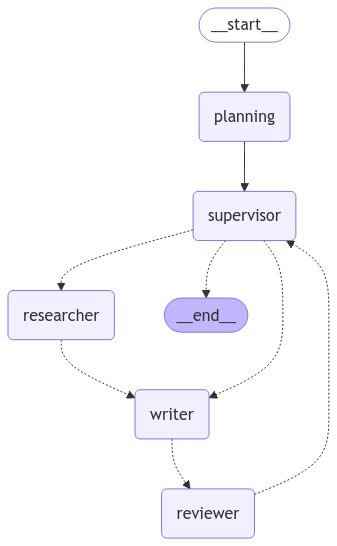

In [58]:
from IPython.display import Image, display

try:
    display(Image(video_script_workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Recursion Limit

Now that we have a real agentic workflow with agent that take decision to the next action, don't forget to add ```"recursion_limit"```to configurable. 99 here is absolutely arbitrary. Adapt it to your needs.

Let's test the agentic workflow.

#### Note
We add "current_chapter_index", "current_chapter_iteration" and "final_script" to the input of the graph to initialise their value. It could have been done by planner node.

In [61]:
prompt = ("I'd like a 2-chapter video of 2 minutes of 450 words on 'AI Won't Take Your Jobs. Those Who Use AI Will!'")

config = {"recursion_limit": 99, "configurable": {"thread_id": "1"}}

example_input = {
    "messages": [("human", prompt)],
    "current_chapter_index": 0,
    "current_chapter_iteration": 0,
    "final_script": ""
}

# Collect all steps from the astream generator
steps = [step for step in video_script_workflow.stream(example_input, config=config, stream_mode="values")]

# Access the last step
last_step = steps[-1]

print(f"Directive: '{prompt}'")

# Print the last message of the last step
last_message = last_step["messages"][-1]

output = last_message.pretty_repr()
print(f"Result: '{output}'")


Directive: 'I'd like a 2-chapter video of 2 minutes of 450 words on 'AI Won't Take Your Jobs. Those Who Use AI Will!''
Result: '================================== Ai Message ==================================
Name: host-producer

# FINAL SCRIPT



## CHAPTER 1

## Opening Section [100 words]

Opening section  |  Hook the audience with a surprising statement  |  ai and job market |  ai and gdp |  ai and job opportunities |  ai and job displacement |  introduce the main topic of the video  |  According to a report by McKinsey, by 2030, AI could boost global GDP by 14% That's a staggering $15.7 trillion! But here's the thing: AI won't take your job. Instead it will open up new opportunities for you to work in. In this video, we'll explore how AI is not a threat to jobs but a powerful tool that can enhance human capabilities and open new opportunities. We'll dive into industries where AI is already making a difference and discuss why AI literacy is crucial for staying competitive in the jo

We have 2 more chapters because the planner automatically add the introduction and the conclusion in the agenda.

#### Additional tips:
##### Retry Policy

**Mistral-3-small** has made impressive progress to handle long conversation. With previous mistral-small, you had to regularly face issue with bad or empty structured output causing random 'KeyError' or 'AttributeError' requiring to recall llm. LangGraph allows you to handle this directly in your graph by adding a retry policy at the node level.

For example we add retry policy to our workers:
```python
workflow.add_node("researcher", researcher_node, retry=RetryPolicy(retry_on=[KeyError, AttributeError], max_attempts=3))
workflow.add_node("writer", writer_node, retry=RetryPolicy(retry_on=[KeyError, AttributeError], max_attempts=3))
workflow.add_node("reviewer", reviewer_node, retry=RetryPolicy(retry_on=[KeyError, AttributeError], max_attempts=3))
```

##### Remaining Steps
["recursion_limit"](https://langchain-ai.github.io/langgraph/concepts/low_level/#recursion-limit) is usefull to ensure that you don't reach a maximum step in your workflow. But you'll certainly want to [return step before hitting that limits](https://langchain-ai.github.io/langgraph/how-tos/return-when-recursion-limit-hits/?h=remaining#with-returning-state).

To handle this case, you will add a remaining_step attribute to your StageGraph and handle it in your supervisor_node:
```python
from langgraph.managed.is_last_step import RemainingSteps

class VideoScriptState(TypedDict):
    [...]
    remaining_steps: RemainingSteps

def supervisor_node(state: VideoScriptState) -> Command[Literal[*members, END]]:
    # ...

    if state["remaining_steps"] <= MIN_REMAINING_STEP:
        return Command(goto=END,...
    
```
LangGraph will automatically track and increment this value for you

# Chapter 7. Where to go from here?

Now, you have practiced the basics of LangGraph to build an agentic workflow. To go further, you can explore more advanced techniques of LangGraph like:

- [Human-in-the-loop](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/)
- [Streaming](https://langchain-ai.github.io/langgraph/concepts/streaming/) and internal state handling (to display progress to user)
- [Persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/)
- [Memory Management](https://langchain-ai.github.io/langgraph/concepts/memory/)

### Excercices
Some ideas for you to practice:

- **Extend research agent** with some RAG capabilities on internet with [tavily search](https://tavily.com/). For example add a [Research team](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/#research-team) You'll practice subgraph and function calling. You can also use Agentic RAG if you want to use internal data. In LangGraph example, the research is done before writing process. Possibility is infinite.

- **Add a final 'relecture node'** that will adjust the final script to ensure smooth transitions and avoid redundancy between sections.


- **Add [parallel execution](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) of chapter and [aggregation (reducer)](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) for final_script**. In our example, we let the supervisor manage the concatenation as the execution is serialized. We should let LangGraph do the work.


In a real-world scenario, you would refine each agent's prompt with more precise guidelines for style, tone, and structure. You can have a look at Video Script agent in my [AI-Agent-Casebook](https://github.com/BittnerPierre/AI-Agent-Casebook/tree/main/app/video_script) on my github.

You can of course easily adapt the use case to your needs. **Audio Overview** feature of [NotebookLM](https://notebooklm.google/) is not that far away.